In [1]:
import pandas as pd

# CSV 
file_path = '/Users/bg.lim/Downloads/TAMU_Agri/New_CGM/bore_bool.csv'

# 
df = pd.read_csv(file_path, encoding="utf-8")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71717 entries, 0 to 71716
Columns: 111 entries, StudyID to EMA_T_Diff.1
dtypes: bool(1), float64(72), int64(18), object(20)
memory usage: 60.3+ MB


# RF

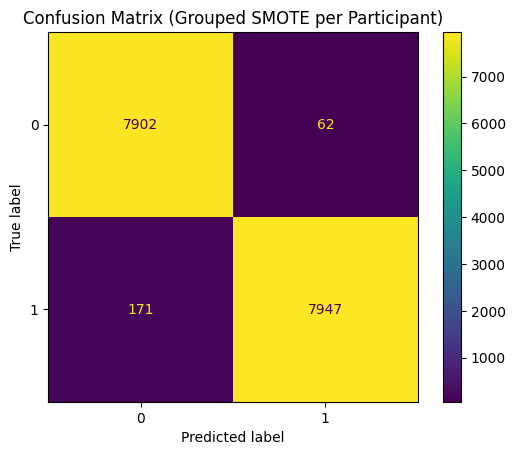

Model Accuracy: 0.9855117522696182

              precision    recall  f1-score   support

           0     0.9788    0.9922    0.9855      7964
           1     0.9923    0.9789    0.9856      8118

    accuracy                         0.9855     16082
   macro avg     0.9855    0.9856    0.9855     16082
weighted avg     0.9856    0.9855    0.9855     16082

      Metric     Score
0   Accuracy  0.985512
1  Precision  0.992259
2     Recall  0.978936
3   F1 Score  0.985552


In [3]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, ConfusionMatrixDisplay
)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Feature and Target definition
X_columns = [
    "Glucose", "is_weekend", "Slope_Pre_1h", "Slope_Pre_2h", "Slope_Pre_2.5h", 
    "Mean_Glucose_Pre_1h", "Mean_Glucose_Pre_2h", "Mean_Glucose_Pre_2.5h",
    "Std_Glucose_Pre_1h", "Std_Glucose_Pre_2h", "Std_Glucose_Pre_2.5h",
    "Time_24h", "bored", "hungry", "How_happy", "How_cheerful", 
    "How_relaxed", "How_stressed", "How_anxious", "How_angry", "How_sad", "How_energetic", 
    "How_tired", "How_lonely", "EMA_T_Diff",
    "mean_intensity_1h", "mean_intensity_2h", "mean_intensity_3h", 
    "HR_mean_1h", "HR_mean_2h", "HR_mean_3h",
    "HR_std_1h", "HR_std_2h", "HR_std_3h",
    "HR_slope_1h", "HR_slope_2h", "HR_slope_3h",
    "TimeInBed", "Efficiency", "Sleep_Diff", "TimeInBed_isnull",
    "Efficiency_isnull", "Sleep_Diff_isnull", "HR_slope_1h_isnull",
    "HR_std_1h_isnull", "HR_mean_1h_isnull"
]

# 2. Load data (assume `df` is already loaded)
df_model = df[X_columns + ["Onset_GE", "StudyID"]].dropna(subset=["Onset_GE"]).copy()

# 3. Convert boolean-like strings to real booleans
for col in ["is_weekend", "hungry", "bored"]:
    df_model[col] = df_model[col].astype(str).str.lower().map({"true": True, "false": False})

# 4. Convert Time_24h to numeric
df_model["Time_24h"] = pd.to_datetime(df_model["Time_24h"], format="%H:%M", errors="coerce")
df_model["Time_24h"] = df_model["Time_24h"].dt.hour + df_model["Time_24h"].dt.minute / 60

# 5. Initialize holders
X_all = []
y_all = []

# 6. Per-participant preprocessing with SMOTE
for study_id, group in df_model.groupby("StudyID"):
    X_participant = group[X_columns].copy()
    y_participant = group["Onset_GE"].astype(int)

    # Convert boolean to int for imputation
    for col in X_participant.select_dtypes(include="bool").columns:
        X_participant[col] = X_participant[col].astype(int)

    # Median imputation
    X_imputed = SimpleImputer(strategy="median").fit_transform(X_participant)

    # Check if both classes exist
    if len(np.unique(y_participant)) > 1:
        class_counts = np.bincount(y_participant)
        minority_class_size = min(class_counts)
        k_neighbors = min(5, minority_class_size - 1)
        if k_neighbors >= 1:
            smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
            X_resampled, y_resampled = smote.fit_resample(X_imputed, y_participant)
        else:
            X_resampled, y_resampled = X_imputed, y_participant.values
    else:
        X_resampled, y_resampled = X_imputed, y_participant.values

    X_all.append(X_resampled)
    y_all.append(y_resampled)

# 7. Combine all participants' data
X_final = np.vstack(X_all)
y_final = np.concatenate(y_all)

# 8. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y_final, test_size=0.2, random_state=42
)

# 9. Train Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 10. Predict and evaluate
y_pred = model.predict(X_test)

# 11. Confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Confusion Matrix (Grouped SMOTE per Participant)")
plt.show()

# 12. Classification report
print("Model Accuracy:", accuracy_score(y_test, y_pred))
print("\n" + classification_report(y_test, y_pred, digits=4))

# 13. Summary metrics
metrics_df = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score"],
    "Score": [
        accuracy_score(y_test, y_pred),
        precision_score(y_test, y_pred),
        recall_score(y_test, y_pred),
        f1_score(y_test, y_pred)
    ]
})
print(metrics_df)


In [5]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


# SHAP 

In [7]:
import shap
import pandas as pd
import numpy as np


# 1. DataFrame으로 변환
X_df_full = pd.DataFrame(X_imputed, columns=X_columns)

# 2. 100개 샘플 무작위 추출 (속도 고려)
X_sample_full = X_df_full.sample(n=100, random_state=42)

# 3. SHAP explainer 생성
explainer = shap.TreeExplainer(model)

# 4. SHAP 값 계산 (Onset 클래스 기준: index 1)
shap_values = explainer.shap_values(X_sample_full, check_additivity=False)

# 5. SHAP 값 정리: 절대값 평균으로 중요도 계산
shap_array = np.array(shap_values[1])  # class 1
shap_importance_all = np.abs(shap_array).mean(axis=0)

# 6. 정리된 중요도 테이블 생성
shap_importance_df = pd.DataFrame({
    "Feature": X_columns,
    "MeanAbsSHAP": shap_importance_all
}).sort_values(by="MeanAbsSHAP", ascending=False)

# 7. 출력 (또는 시각화 가능)
print(shap_importance_df)


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


                  Feature  MeanAbsSHAP
1              is_weekend     0.049843
13                 hungry     0.048971
11               Time_24h     0.039974
22              How_tired     0.031914
18            How_anxious     0.025086
17           How_stressed     0.021947
16            How_relaxed     0.019150
15           How_cheerful     0.018954
14              How_happy     0.015678
21          How_energetic     0.012689
25      mean_intensity_1h     0.012496
24             EMA_T_Diff     0.012088
27      mean_intensity_3h     0.010543
39             Sleep_Diff     0.010323
33              HR_std_3h     0.009730
0                 Glucose     0.008694
26      mean_intensity_2h     0.008418
36            HR_slope_3h     0.008134
38             Efficiency     0.007702
32              HR_std_2h     0.007554
20                How_sad     0.007308
23             How_lonely     0.006706
2            Slope_Pre_1h     0.006674
3            Slope_Pre_2h     0.006484
9      Std_Glucose_Pre_2h

In [10]:
import shap
import pandas as pd
import numpy as np

# === [1] Define top N features (e.g., 6 or 10)
top_features = shap_importance_df["Feature"].head(6).tolist()

# === [2] Prepare sample DataFrame
# If not done yet: X_sample_full = X_df_full.sample(n=100, random_state=42)
# Ensure it contains all top features
X_samples = X_sample_full[top_features]  # shape: (100, top_N)

# === [3] Initialize SHAP explainer only ONCE
explainer = shap.TreeExplainer(model, approximate=True)

# === [4] Function to show waterfall plot for a given sample index
def show_waterfall(idx):
    x_row = X_samples.iloc[[idx]]  # keep as DataFrame
    shap_values_single = explainer.shap_values(x_row, check_additivity=False)
    
    explanation = shap.Explanation(
        values=shap_values_single[1][0],
        base_values=explainer.expected_value[1],
        data=x_row.values[0],
        feature_names=top_features
    )
    
    shap.plots.waterfall(explanation)


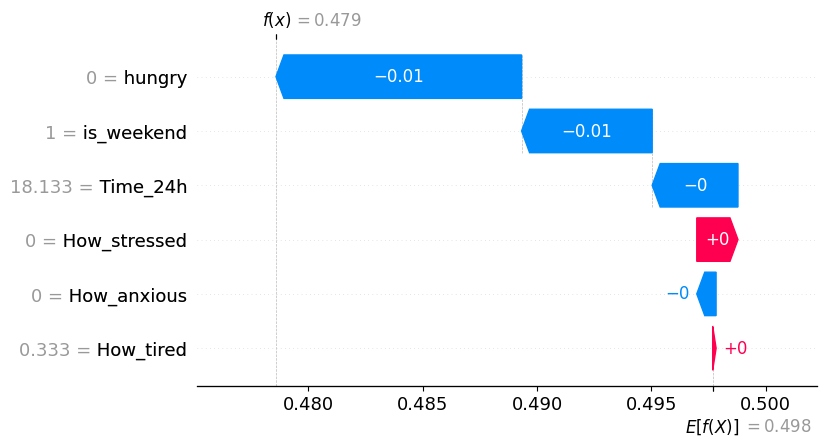

In [18]:
# The SHAP waterfall plot is a local explanation method that shows how each feature contributed to the prediction for a single sample.
show_waterfall(19)



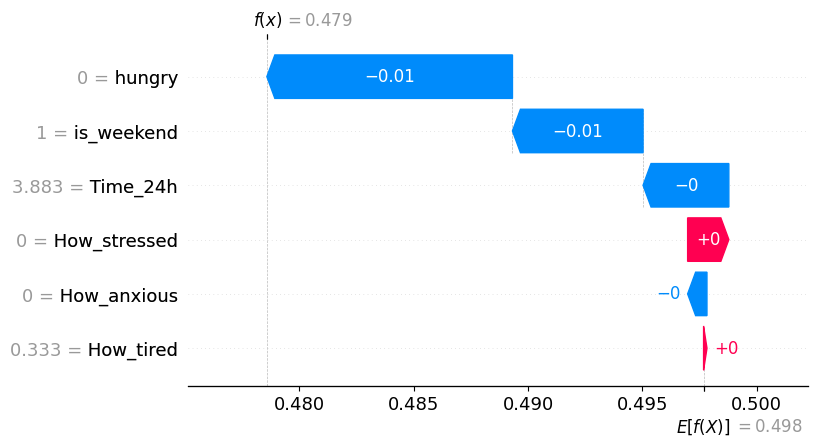

In [20]:
# The SHAP waterfall plot is a local explanation method that shows how each feature contributed to the prediction for a single sample.
show_waterfall(30)



X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but Ran

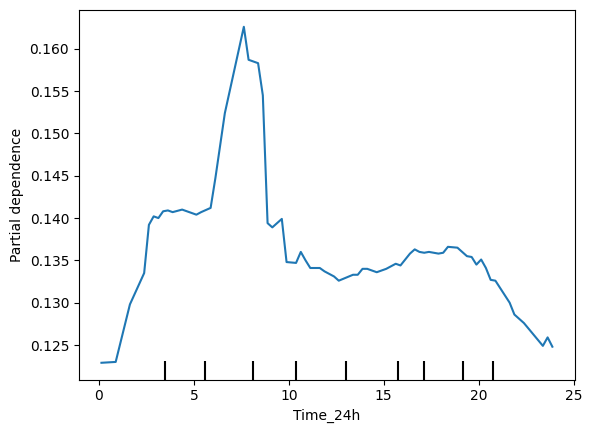

In [30]:
from sklearn.inspection import PartialDependenceDisplay


PartialDependenceDisplay.from_estimator(
    model, 
    X_sample_full, 
    features=["Time_24h"],  # or "Time_24h", "is_weekend", ...
    kind="average",       # PDP
    target=1              # class 1 = Onset
)



In [46]:
# 1. 유효한 데이터만 필터링
df_valid = df[(~df["Time_24h"].isna()) & (~df["Onset_GE"].isna())].copy()

# 2. 시간대(정수 단위)로 그룹화 (0시 ~ 23시)
df_valid["Hour"] = df_valid["Time_24h"].astype(int)

# 3. 시간별 Onset=1 비율 계산
onset_rate_by_hour = (
    df_valid.groupby("Hour")["Onset_GE"]
    .apply(lambda x: (x == 1).mean())
    .reset_index(name="Onset_1_Rate")
)

print(onset_rate_by_hour)


    Hour  Onset_1_Rate
0      0      0.011407
1      1      0.009254
2      2      0.008715
3      3      0.008715
4      4      0.006550
5      5      0.006572
6      6      0.013797
7      7      0.021146
8      8      0.029067
9      9      0.025224
10    10      0.029775
11    11      0.031038
12    12      0.049125
13    13      0.039747
14    14      0.038732
15    15      0.043713
16    16      0.038859
17    17      0.039336
18    18      0.046106
19    19      0.049530
20    20      0.052930
21    21      0.042298
22    22      0.029096
23    23      0.024051


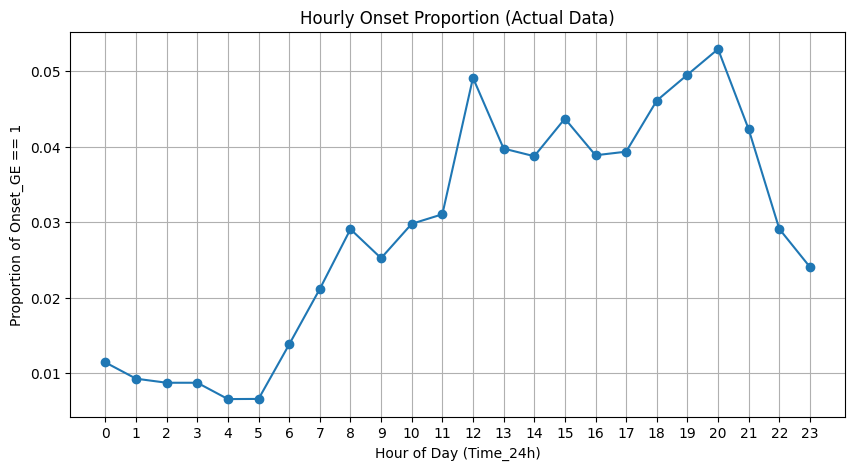

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(onset_rate_by_hour["Hour"], onset_rate_by_hour["Onset_1_Rate"], marker='o')
plt.xticks(range(0, 24))
plt.xlabel("Hour of Day (Time_24h)")
plt.ylabel("Proportion of Onset_GE == 1")
plt.title("Hourly Onset Proportion (Actual Data)")
plt.grid(True)
plt.show()


In [44]:
# Time_24h가 "HH:MM" 문자열일 경우, 먼저 시각 → 시간(float)으로 변환
df["Time_24h"] = pd.to_datetime(df["Time_24h"], format="%H:%M", errors="coerce")
df["Time_24h"] = df["Time_24h"].dt.hour + df["Time_24h"].dt.minute / 60


# 1. Time_24h가 존재하고 Onset_GE가 결측이 아닌 행 필터링
df_valid = df[(~df["Time_24h"].isna()) & (~df["Onset_GE"].isna())]

# 2. 오전 시간대(6~9시) 필터링
morning = df_valid[(df_valid["Time_24h"] >= 6) & (df_valid["Time_24h"] < 9)]

# 3. Onset이 1인 비율 계산
morning_onset_rate = (morning["Onset_GE"] == 1).mean()

# 4. 전체 onset 비율과 비교용
overall_onset_rate = (df_valid["Onset_GE"] == 1).mean()

print(f"Proportion of Onset_GE==1 in morning (6~9h): {morning_onset_rate:.3f}")
print(f"Overall Onset_GE==1 proportion: {overall_onset_rate:.3f}")


Proportion of Onset_GE==1 in morning (6~9h): 0.021
Overall Onset_GE==1 proportion: 0.028


X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names


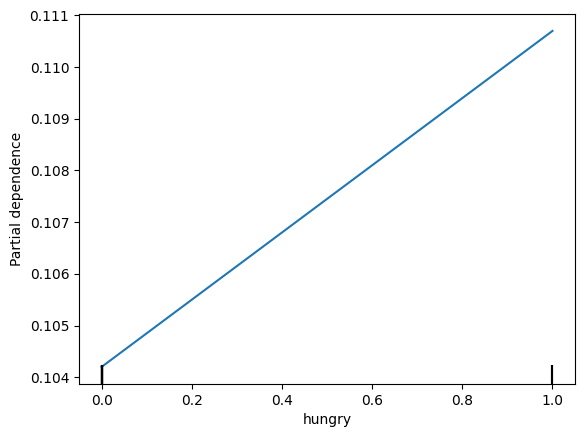

In [32]:
from sklearn.inspection import PartialDependenceDisplay

PartialDependenceDisplay.from_estimator(
    model,
    X_sample_full,
    features=["hungry"],   # or "is_weekend"
    kind="average",
    target=1
)


In [50]:
# 1. hungry Onset_GE 
df_valid = df[(~df["hungry"].isna()) & (~df["Onset_GE"].isna())].copy()

# 2. hungry (0/1)
df_valid["hungry"] = df_valid["hungry"].astype(int)

# 3. hungry Onset_GE == 1 
onset_by_hungry = (
    df_valid.groupby("hungry")["Onset_GE"]
    .apply(lambda x: (x == 1).mean())
    .reset_index(name="Onset_1_Rate")
)

print(onset_by_hungry)


   hungry  Onset_1_Rate
0       0      0.026625
1       1      0.032504


X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names


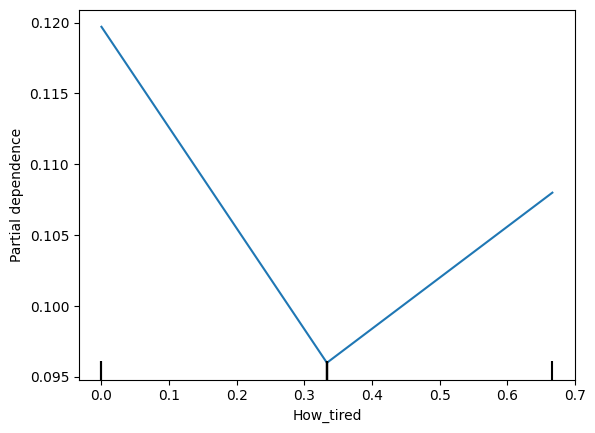

In [54]:
from sklearn.inspection import PartialDependenceDisplay


PartialDependenceDisplay.from_estimator(
    model, 
    X_sample_full, 
    features=["How_tired"],  # or "Time_24h", "is_weekend", ...
    kind="average",       # PDP
    target=1              # class 1 = Onset
)


In [70]:
# 1. 유효한 행 필터링
df_valid = df[(~df["How_tired"].isna()) & (~df["Onset_GE"].isna())].copy()

# 2. 구간 정의
bins = [-0.01, 0.35, 0.7, 1.0]
labels = ["Low (0–0.35)", "Mid (0.35–0.7)", "High (0.7–1.0)"]

df_valid["tired_group"] = pd.cut(df_valid["How_tired"], bins=bins, labels=labels)

# 3. Onset 비율 계산
onset_by_group = (
    df_valid.groupby("tired_group")["Onset_GE"]
    .apply(lambda x: (x == 1).mean())
    .reset_index(name="Onset_1_Rate")
)

print(onset_by_group)


      tired_group  Onset_1_Rate
0    Low (0–0.35)      0.028961
1  Mid (0.35–0.7)      0.021647
2  High (0.7–1.0)      0.035505


X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names


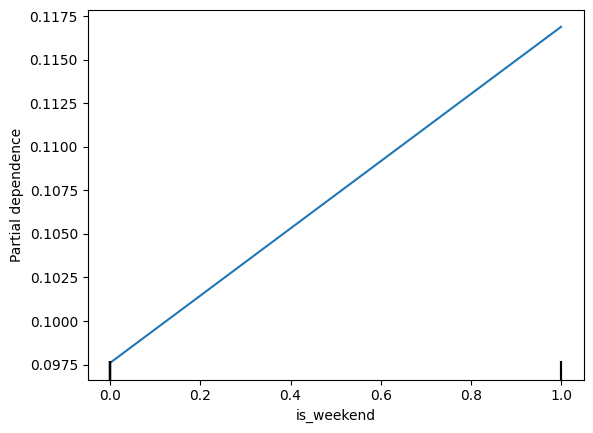

In [36]:
from sklearn.inspection import PartialDependenceDisplay

PartialDependenceDisplay.from_estimator(
    model,
    X_sample_full,
    features=["is_weekend"],   # or "is_weekend"
    kind="average",
    target=1
)


In [52]:
# 1. is_weekend와 Onset_GE가 모두 유효한 행만 필터링
df_valid = df[(~df["is_weekend"].isna()) & (~df["Onset_GE"].isna())].copy()

# 2. is_weekend를 정수형으로 변환 (0 또는 1)
df_valid["is_weekend"] = df_valid["is_weekend"].astype(int)

# 3. 그룹별 Onset=1 비율 계산
onset_by_weekend = (
    df_valid.groupby("is_weekend")["Onset_GE"]
    .apply(lambda x: (x == 1).mean())
    .reset_index(name="Onset_1_Rate")
)

print(onset_by_weekend)


   is_weekend  Onset_1_Rate
0           0      0.029011
1           1      0.026708


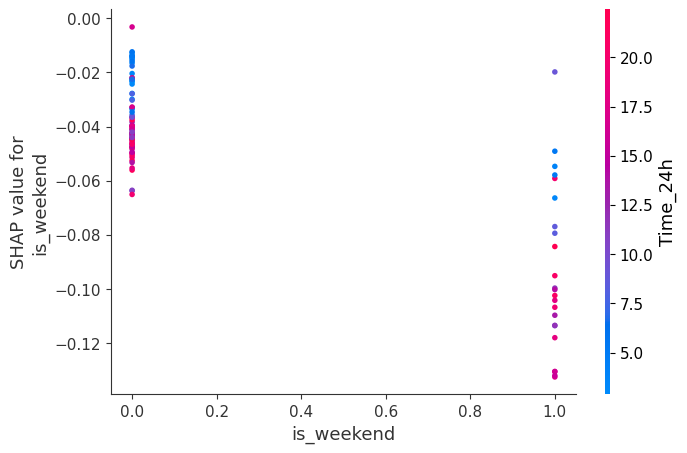

In [38]:
shap.dependence_plot(
    "is_weekend",         # feature name
    shap_values[1],       # SHAP values for class 1 (Onset)
    X_sample_full         # feature DataFrame used for SHAP computation
)
